In [4]:
import torch
from torch import nn
import dltools

In [5]:
n_train = 50
x_train ,_= torch.sort(torch.rand(n_train) * 5)
print(x_train)

tensor([0.1129, 0.3243, 0.3533, 0.4707, 0.5366, 0.5379, 0.9617, 1.0785, 1.0853,
        1.1230, 1.1869, 1.2044, 1.2482, 1.2489, 1.5524, 1.6755, 1.7494, 1.7721,
        2.0848, 2.1355, 2.2616, 2.6201, 2.9712, 3.0060, 3.0197, 3.0623, 3.0800,
        3.1567, 3.1652, 3.2085, 3.2129, 3.3408, 3.4125, 3.4181, 3.4765, 3.5414,
        3.6860, 3.9899, 4.2301, 4.2367, 4.3763, 4.4069, 4.4414, 4.5529, 4.5646,
        4.6442, 4.7339, 4.7719, 4.8527, 4.9842])


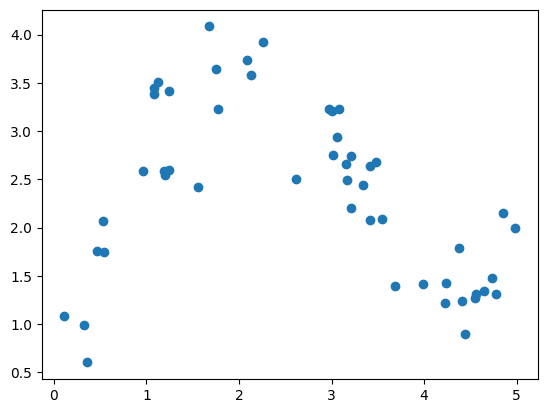

In [6]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,))
dltools.plt.scatter(x_train,y_train)
x_test = torch.arange(0,5,0.1)
n_test = len(x_test)
y_truth = f(x_test)


In [7]:
def plot_kernel_reg(y_hat):
    dltools.plot(x_test,[y_truth,y_hat],'x','y',legend=['Truth','Pred'],
                 xlim=[0,5],ylim=[0,5])
    dltools.plt.plot(x_train,y_train,'o',alpha=0.5)

In [8]:
torch.repeat_interleave(y_train.mean(),n_test)

tensor([2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409,
        2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409,
        2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409,
        2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409,
        2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409, 2.3409,
        2.3409, 2.3409, 2.3409, 2.3409, 2.3409])

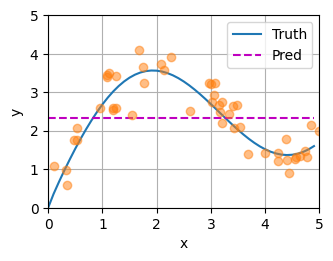

In [9]:
y_hat = torch.repeat_interleave(y_train.mean(),n_test
                            )
plot_kernel_reg(y_hat)

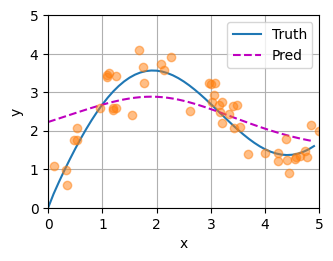

In [10]:
X_repeat = x_test.repeat_interleave(n_train).reshape(-1,n_train)
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
y_hat = torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)


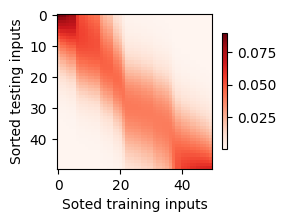

In [11]:
import dltools
dltools.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),xlabel='Soted training inputs',ylabel='Sorted testing inputs')

In [22]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
        
    def forward(self, queries, keys, values):
        # 规定一下queries的形状: (查询个数, '键值'对的个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys)* self.w) ** 2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [23]:
# 开始训练
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))

keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

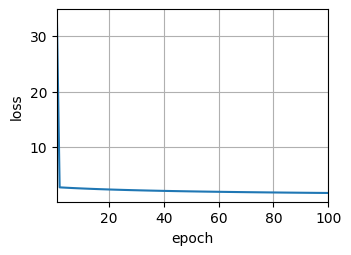

In [28]:
net =NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr = 0.5)
animator = dltools.Animator(xlabel='epoch',ylabel='loss',xlim = [1,100])
for epoch in range(100):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch{epoch + 1},loss{float(l.sum()):.6f}')
    animator.add(epoch+1,float(l.sum()))

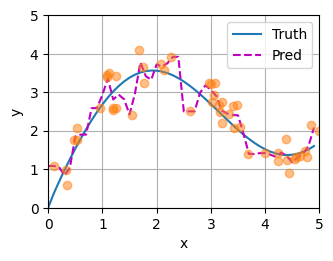

In [29]:
keys = x_train.repeat((n_test,1))
values = y_train.repeat((n_test,1))
y_hat = net(x_test,keys,values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)